# Model-X knockoffs: compare MVR vs ME vs SDP constructions

+ SDP: semi-definite programming knockoffs
+ MVR: Minimum variance-based reconstructability knockoffs
+ ME: Maximum entropy knockoffs

MVR and ME knockoffs are proposed in Asher & Jenson 2021, while SDP knockoffs are the "gold standard" proposed in candes et al. 2018. 

In [51]:
using Revise
using Knockoffs
using Random
using GLMNet
using Distributions
using LinearAlgebra
using ToeplitzMatrices
using StatsBase
using Plots
gr(fmt=:png);


## Correlation between $(X_i, X_j) = \rho = 0.5$

Here the covariance matrix is

\begin{aligned}
\Sigma = 
\begin{pmatrix}
    1 & \rho & \rho & ... & \rho\\
    \rho & 1 & & ... & \rho\\
    \vdots & & & 1 & \vdots \\
    \rho & \cdots & & & 1
\end{pmatrix}
\end{aligned}
SDP knockoffs are provably powerless in this situation.

Example from https://amspector100.github.io/knockpy/mrcknock.html


In [52]:
seed = 2022

# simulate X
Random.seed!(seed)
n = 600
p = 300
ρ = 0.5
Σ = (1-ρ) * I + ρ * ones(p, p)
μ = zeros(p)
L = cholesky(Σ).L
X = randn(n, p) * L # var(X) = L var(N(0, 1)) L' = var(Σ)

# simulate y
Random.seed!(seed)
k = Int(0.2p)
βtrue = zeros(p)
βtrue[1:k] .= rand(-1:2:1, k) .* rand(Uniform(0.5, 1), k)
shuffle!(βtrue)
correct_position = findall(!iszero, βtrue)
y = X * βtrue + randn(n);

SDP knockoffs

  9.025537 seconds (1.27 M allocations: 1.261 GiB, 7.60% gc time, 1.21% compilation time)
  1.383599 seconds (795 allocations: 42.130 MiB)


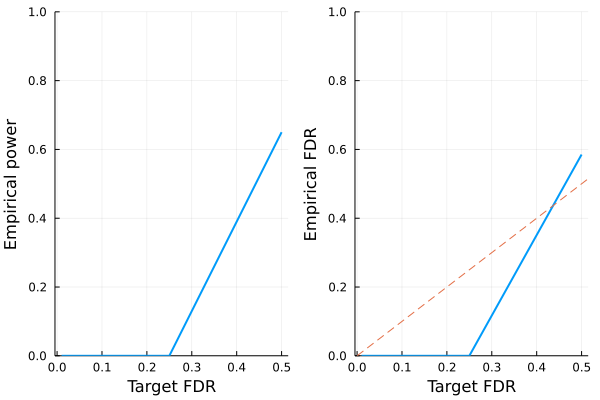

In [53]:
@time Xko_sdp = modelX_gaussian_knockoffs(X, :sdp, μ, Σ);
@time knockoff_filter = fit_lasso(y, Xko_sdp.X, Xko_sdp.X̃, debias=false)

# visualize FDR and power
FDR = knockoff_filter.fdr_target
empirical_power = Float64[]
empirical_fdr = Float64[]
for i in eachindex(FDR)
    # extract beta for current fdr
    βknockoff = knockoff_filter.βs[i]
    
    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

MVR knockoffs

  1.482522 seconds (12.68 k allocations: 1.425 GiB, 32.38% gc time)
  2.607496 seconds (795 allocations: 44.063 MiB)


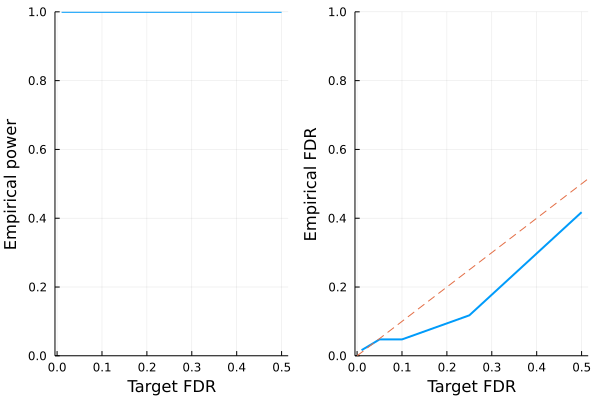

In [54]:
@time Xko_mvr = modelX_gaussian_knockoffs(X, :mvr, μ, Σ);
@time knockoff_filter = fit_lasso(y, Xko_mvr.X, Xko_mvr.X̃, debias=false)


# visualize FDR and power
FDR = knockoff_filter.fdr_target
empirical_power = Float64[]
empirical_fdr = Float64[]
for i in eachindex(FDR)
    # extract beta for current fdr
    βknockoff = knockoff_filter.βs[i]
    
    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

Max Entropy knockoffs

  0.465639 seconds (7.28 k allocations: 17.091 MiB)
  2.553662 seconds (795 allocations: 44.063 MiB)


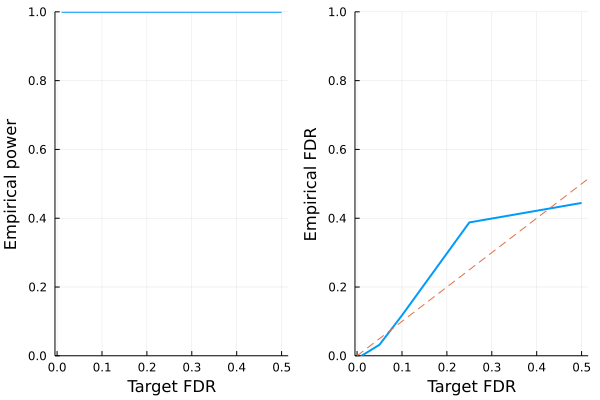

In [55]:
@time Xko_maxent = modelX_gaussian_knockoffs(X, :maxent, μ, Σ);
@time knockoff_filter = fit_lasso(y, Xko_maxent.X, Xko_maxent.X̃, debias=false)


# visualize FDR and power
FDR = knockoff_filter.fdr_target
empirical_power = Float64[]
empirical_fdr = Float64[]
for i in eachindex(FDR)
    # extract beta for current fdr
    βknockoff = knockoff_filter.βs[i]
    
    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

## AR(1)

Here we represent $X_1 \sim N(0, 1)$ and for each $j$ 
$$X_j = \rho_j X_{j-1} + \sqrt{1 - \rho_j^2}Z_j$$
where $Z_j \sim N(0, 1)$ and $\rho_j \sim beta(3, 1)$. After sampling the correlations, if  $\lambda_{min}(\Sigma) < 0.001$, we add $(0.001 - \lambda_{min}(\Sigma))I_p$ to increase the eigenvalues above a numerical tolerance and then rescale to a correlation matrix. 

In [56]:
seed = 2022

# simulate X
Random.seed!(seed)
n = 500
p = 500
Σ = simulate_AR1(p)
μ = zeros(p)
L = cholesky(Σ).L
X = randn(n, p) * L # var(X) = L var(N(0, 1)) L' = Σ

# simulate y
Random.seed!(seed)
k = Int(0.1p)
βtrue = zeros(p)
βtrue[1:k] .= rand(-1:2:1, k) .* rand(Uniform(1, 2), k)
shuffle!(βtrue)
correct_position = findall(!iszero, βtrue)
y = X * βtrue + randn(n);

SDP knockoffs

102.041044 seconds (3.07 M allocations: 5.512 GiB, 0.90% gc time)
  1.309893 seconds (795 allocations: 63.638 MiB, 4.77% gc time)


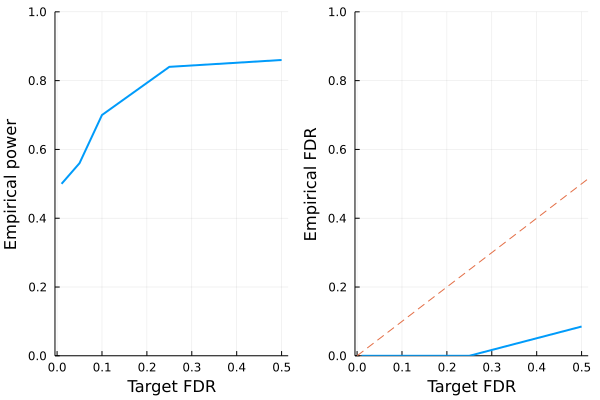

In [57]:
@time Xko_sdp = modelX_gaussian_knockoffs(X, :sdp, μ, Σ);
@time knockoff_filter = fit_lasso(y, Xko_sdp.X, Xko_sdp.X̃, debias=false)


# visualize FDR and power
FDR = knockoff_filter.fdr_target
empirical_power = Float64[]
empirical_fdr = Float64[]
for i in eachindex(FDR)
    # extract beta for current fdr
    βknockoff = knockoff_filter.βs[i]
    
    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

MVR knockoffs

 68.284131 seconds (300.08 k allocations: 93.173 GiB, 9.56% gc time)
  1.045063 seconds (795 allocations: 63.638 MiB, 0.64% gc time)


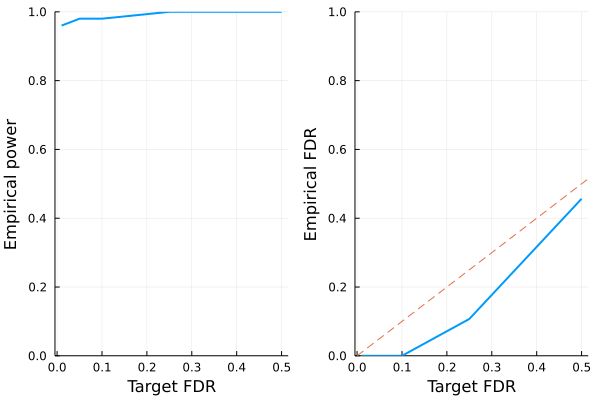

In [58]:
@time Xko_mvr = modelX_gaussian_knockoffs(X, :mvr, μ, Σ);
@time knockoff_filter = fit_lasso(y, Xko_mvr.X, Xko_mvr.X̃, debias=false)


# visualize FDR and power
FDR = knockoff_filter.fdr_target
empirical_power = Float64[]
empirical_fdr = Float64[]
for i in eachindex(FDR)
    # extract beta for current fdr
    βknockoff = knockoff_filter.βs[i]
    
    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

Max Entropy knockoffs

  3.324632 seconds (16.08 k allocations: 33.624 MiB)
  1.088523 seconds (795 allocations: 63.638 MiB, 0.71% gc time)


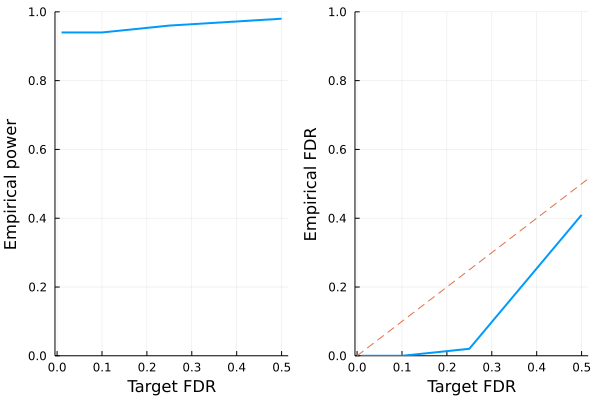

In [59]:
@time Xko_maxent = modelX_gaussian_knockoffs(X, :maxent, μ, Σ);
@time knockoff_filter = fit_lasso(y, Xko_maxent.X, Xko_maxent.X̃, debias=false)


# visualize FDR and power
FDR = knockoff_filter.fdr_target
empirical_power = Float64[]
empirical_fdr = Float64[]
for i in eachindex(FDR)
    # extract beta for current fdr
    βknockoff = knockoff_filter.βs[i]
    
    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

## AR1 (corr)

Here we represent $X_1 \sim N(0, 1)$ and for each $j$ 
$$X_j = \rho_j X_{j-1} + \sqrt{1 - \rho_j^2}Z_j$$
where $Z_j \sim N(0, 1)$ and $\rho_j \sim beta(3, 1)$. After sampling the correlations, if  $\lambda_{min}(\Sigma) < 0.001$, we add $(0.001 - \lambda_{min}(\Sigma))I_p$ to increase the eigenvalues above a numerical tolerance and then rescale to a correlation matrix. 

Since non-nulls are often clustered together in genetic studies, in the $AR1(Corr)$
setting, we partially capture this idea by letting the non-nulls lie along a single continuous block of
features.

In [61]:
seed = 2022

# simulate X
Random.seed!(seed)
n = 500
p = 500
Σ = simulate_AR1(p)
μ = zeros(p)
L = cholesky(Σ).L
X = randn(n, p) * L # var(X) = L var(N(0, 1)) L' = Σ

# simulate y
Random.seed!(seed)
k = Int(0.1p)
βtrue = zeros(p)
βtrue[1:k] .= rand(-1:2:1, k) .* rand(Uniform(1, 2), k)
correct_position = findall(!iszero, βtrue)
y = X * βtrue + randn(n);

SDP 

102.445124 seconds (3.07 M allocations: 5.512 GiB, 1.29% gc time)
  1.199826 seconds (795 allocations: 63.638 MiB, 4.34% gc time)


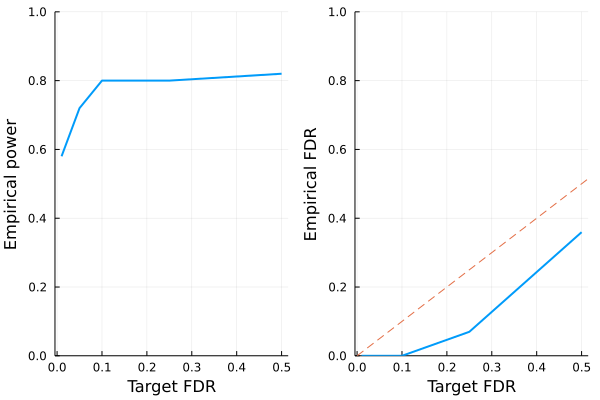

In [62]:
@time Xko_sdp = modelX_gaussian_knockoffs(X, :sdp, μ, Σ);
@time knockoff_filter = fit_lasso(y, Xko_sdp.X, Xko_sdp.X̃, debias=false)


# visualize FDR and power
FDR = knockoff_filter.fdr_target
empirical_power = Float64[]
empirical_fdr = Float64[]
for i in eachindex(FDR)
    # extract beta for current fdr
    βknockoff = knockoff_filter.βs[i]
    
    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

MVR

 61.270518 seconds (300.08 k allocations: 93.173 GiB, 10.20% gc time)
  0.849521 seconds (795 allocations: 63.638 MiB)


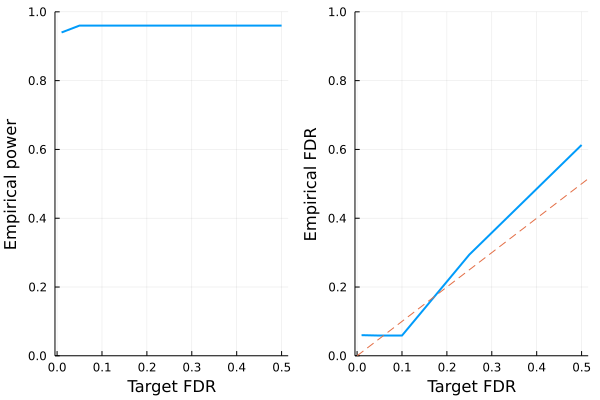

In [63]:
@time Xko_mvr = modelX_gaussian_knockoffs(X, :mvr, μ, Σ);
@time knockoff_filter = fit_lasso(y, Xko_mvr.X, Xko_mvr.X̃, debias=false)


# visualize FDR and power
FDR = knockoff_filter.fdr_target
empirical_power = Float64[]
empirical_fdr = Float64[]
for i in eachindex(FDR)
    # extract beta for current fdr
    βknockoff = knockoff_filter.βs[i]
    
    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

ME

  3.195706 seconds (16.08 k allocations: 33.624 MiB)
  0.954149 seconds (795 allocations: 63.638 MiB, 0.90% gc time)


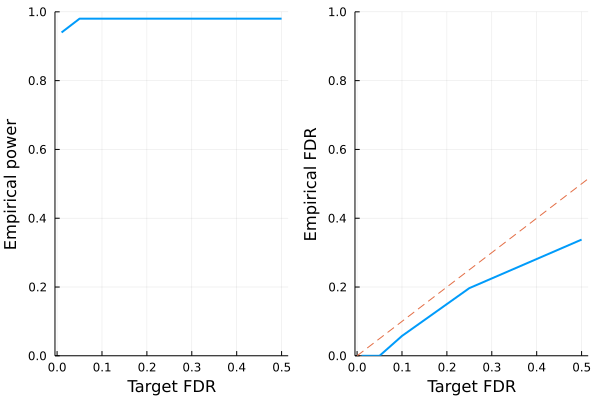

In [64]:
@time Xko_maxent = modelX_gaussian_knockoffs(X, :maxent, μ, Σ);
@time knockoff_filter = fit_lasso(y, Xko_maxent.X, Xko_maxent.X̃, debias=false)


# visualize FDR and power
FDR = knockoff_filter.fdr_target
empirical_power = Float64[]
empirical_fdr = Float64[]
for i in eachindex(FDR)
    # extract beta for current fdr
    βknockoff = knockoff_filter.βs[i]
    
    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

## AR(1)

Here is a different kind of AR(1) model, where correlation decreases constantly

\begin{aligned}
\Sigma = 
\begin{pmatrix}
    1 & \rho & \rho^2 & ... & \rho^p\\
    \rho & 1 & & ... & \rho^{p-1}\\
    \vdots & & & 1 & \vdots \\
    \rho^p & \cdots & & & 1
\end{pmatrix}
\end{aligned}

In [40]:
seed = 123

# simulate X
Random.seed!(seed)
n = 400
p = 300
ρ = 0.4
Σ = Matrix(SymmetricToeplitz(ρ.^(0:(p-1)))) # true covariance matrix
μ = zeros(p)
L = cholesky(Σ).L
X = randn(n, p) * L # var(X) = L var(N(0, 1)) L' = var(Σ)

# simulate y
Random.seed!(seed)
k = Int(0.1p)
βtrue = zeros(p)
βtrue[1:k] .= 0.5randn(k)
shuffle!(βtrue)
correct_position = findall(!iszero, βtrue)
y = X * βtrue + randn(n);

SDP

 97.751177 seconds (3.07 M allocations: 5.512 GiB, 0.91% gc time)
  1.263984 seconds (795 allocations: 63.638 MiB, 4.32% gc time)


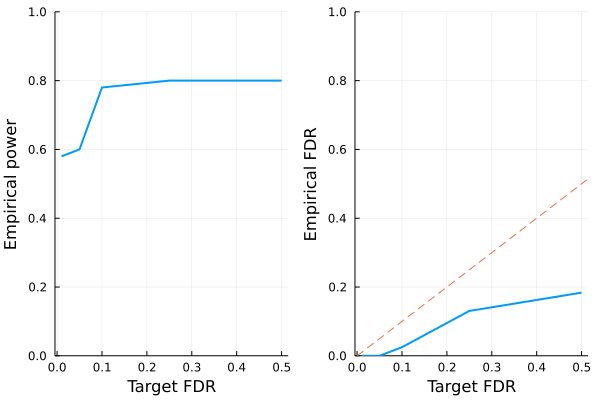

In [65]:
@time Xko_sdp = modelX_gaussian_knockoffs(X, :sdp, μ, Σ);
@time knockoff_filter = fit_lasso(y, Xko_sdp.X, Xko_sdp.X̃, debias=false)


# visualize FDR and power
FDR = knockoff_filter.fdr_target
empirical_power = Float64[]
empirical_fdr = Float64[]
for i in eachindex(FDR)
    # extract beta for current fdr
    βknockoff = knockoff_filter.βs[i]
    
    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

MVR

 61.505705 seconds (300.08 k allocations: 93.173 GiB, 9.99% gc time)
  0.867120 seconds (795 allocations: 63.638 MiB)


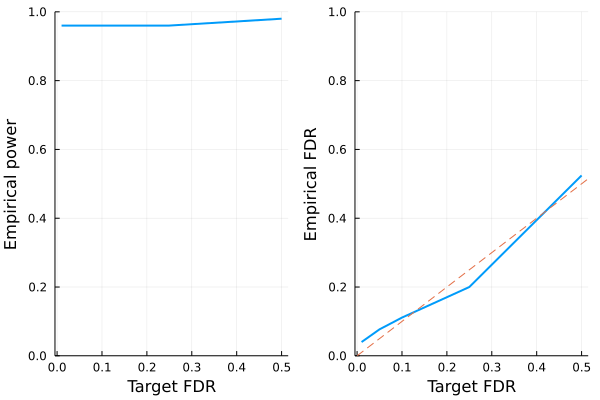

In [66]:
@time Xko_mvr = modelX_gaussian_knockoffs(X, :mvr, μ, Σ);
@time knockoff_filter = fit_lasso(y, Xko_mvr.X, Xko_mvr.X̃, debias=false)


# visualize FDR and power
FDR = knockoff_filter.fdr_target
empirical_power = Float64[]
empirical_fdr = Float64[]
for i in eachindex(FDR)
    # extract beta for current fdr
    βknockoff = knockoff_filter.βs[i]
    
    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

ME

  3.177617 seconds (16.08 k allocations: 33.624 MiB)
  0.886583 seconds (795 allocations: 63.638 MiB, 1.09% gc time)


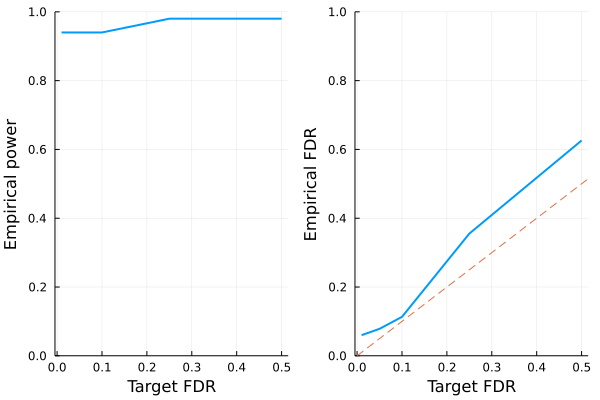

In [67]:
@time Xko_maxent = modelX_gaussian_knockoffs(X, :maxent, μ, Σ);
@time knockoff_filter = fit_lasso(y, Xko_maxent.X, Xko_maxent.X̃, debias=false)


# visualize FDR and power
FDR = knockoff_filter.fdr_target
empirical_power = Float64[]
empirical_fdr = Float64[]
for i in eachindex(FDR)
    # extract beta for current fdr
    βknockoff = knockoff_filter.βs[i]
    
    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylim=(0, 1),ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

## Conclusion

+ MVR and ME knockoffs are typically more powerful than SDP knockoffs
+ MVR and ME knockoffs are also 10-100x faster to generate than SDP knockoffs, because MVR and ME use coordinate descent. SDP could use this as well but that is not implemented